In [1]:
import json
import numpy as np

def quaternion_to_rotation_matrix(qw, qx, qy, qz):
    '''Convert quaternion to 3x3 rotation matrix.'''
    R = np.array([
        [1 - 2*qy**2 - 2*qz**2, 2*qx*qy - 2*qz*qw, 2*qx*qz + 2*qy*qw],
        [2*qx*qy + 2*qz*qw, 1 - 2*qx**2 - 2*qz**2, 2*qy*qz - 2*qx*qw],
        [2*qx*qz - 2*qy*qw, 2*qy*qz + 2*qx*qw, 1 - 2*qx**2 - 2*qy**2]
    ])
    return R

In [53]:
def parse_transform_file(file_path):
    """
    Parse a transform file and return a list of transforms.
    Supports both 3x4 and 4x4 matrix formats.
    """
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    transforms = {}
    
    if 'frames' in data:
        # transfoms.json
        data = data['frames']
        for item in data:
            # 3x4 matrix format (transform_train.json)
            transform = item["transform_matrix"]
            # Extract rotation (3x3) and translation (3x1)
            R = [transform[i][:3] for i in range(3)]
            t = [transform[i][3] for i in range(3)]
            transforms[item["file_path"].split("/")[-1]] = {'rotation': R, 'translation': t}
    
    else:
        # transforms_train.json
        for item in data:
            # 4x4 matrix format (transforms.json)
            transform = item['transform']
            # Extract rotation (3x3) and translation (3x1)
            R = [transform[i][:3] for i in range(3)]
            t = [transform[i][3] for i in range(3)]
            transforms[item["file_path"].split("\\")[-1]] = {'rotation': R, 'translation': t}
    
    return transforms

def parse_transform_files(file_paths):
    """
    Parse multiple transform files and return a list of all parsed transforms.
    """
    all_transforms = []
    
    for file_path in file_paths:
        transforms = parse_transform_file(file_path)
        all_transforms.append(transforms)
    
    return all_transforms

# Example usage:
refine_paths = ['./outputs/camera1127/transforms_train.json','./outputs/camera1127/transforms_eval.json']
transform_path = './data/nerfstudio/poster/transforms.json'
transforms = parse_transform_file(transform_path)
refined_transforms = parse_transform_files(refine_paths)

In [54]:
refined_transforms

[{'frame_00001.png': {'rotation': [[0.8504081964492798,
     0.1754688024520874,
     -0.49600058794021606],
    [-0.523248016834259, 0.18364156782627106, -0.8321582078933716],
    [-0.054931461811065674, 0.9672054648399353, 0.24798400700092316]],
   'translation': [-0.5559717416763306,
    -0.5978692173957825,
    -0.12046844512224197]},
  'frame_00002.png': {'rotation': [[0.8281749486923218,
     0.1936497986316681,
     -0.5259523987770081],
    [-0.5575795769691467, 0.18949462473392487, -0.8082059025764465],
    [-0.05684376507997513, 0.9625961780548096, 0.26490992307662964]],
   'translation': [-0.5775068402290344,
    -0.5577907562255859,
    -0.10823742300271988]},
  'frame_00003.png': {'rotation': [[0.8053093552589417,
     0.21259471774101257,
     -0.5534259080886841],
    [-0.5905300378799438, 0.20505961775779724, -0.7805286049842834],
    [-0.05245093256235123, 0.9553816318511963, 0.29068002104759216]],
   'translation': [-0.6035266518592834,
    -0.5267450213432312,
    -0

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_multiple_transforms_with_lines(gt_rotations, gt_translations, est_rotations, est_translations):
    """
    Visualize multiple pairs of ground truth and estimated camera transformations in 3D space with lines connecting them.
    """
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Loop over each pair of ground truth and estimated transforms
    for i in range(len(gt_rotations)):
        # Ground truth position and orientation
        gt_pos = np.array(gt_translations[i])
        gt_R = np.array(gt_rotations[i])
        # Estimated position and orientation
        est_pos = np.array(est_translations[i])
        est_R = np.array(est_rotations[i])

        # Plot the ground truth camera position (translation vector)
        ax.scatter(gt_pos[0], gt_pos[1], gt_pos[2], c='g', label=f"GT Position {i+1}" if i == 0 else "")
        
        # Plot the estimated camera position (translation vector)
        ax.scatter(est_pos[0], est_pos[1], est_pos[2], c='r', label=f"Estimated Position {i+1}" if i == 0 else "")

        # Plot the ground truth camera orientation (axes)
        ax.quiver(gt_pos[0], gt_pos[1], gt_pos[2],
                  gt_R[0][0], gt_R[1][0], gt_R[2][0], length=0.5, color='b', alpha=0.6, label="GT X-Axis" if i == 0 else "")
        ax.quiver(gt_pos[0], gt_pos[1], gt_pos[2],
                  gt_R[0][1], gt_R[1][1], gt_R[2][1], length=0.5, color='g', alpha=0.6, label="GT Y-Axis" if i == 0 else "")
        ax.quiver(gt_pos[0], gt_pos[1], gt_pos[2],
                  gt_R[0][2], gt_R[1][2], gt_R[2][2], length=0.5, color='y', alpha=0.6, label="GT Z-Axis" if i == 0 else "")

        # Plot the estimated camera orientation (axes)
        ax.quiver(est_pos[0], est_pos[1], est_pos[2],
                  est_R[0][0], est_R[1][0], est_R[2][0], length=0.5, color='b', alpha=0.6, label="Estimated X-Axis" if i == 0 else "")
        ax.quiver(est_pos[0], est_pos[1], est_pos[2],
                  est_R[0][1], est_R[1][1], est_R[2][1], length=0.5, color='g', alpha=0.6, label="Estimated Y-Axis" if i == 0 else "")
        ax.quiver(est_pos[0], est_pos[1], est_pos[2],
                  est_R[0][2], est_R[1][2], est_R[2][2], length=0.5, color='y', alpha=0.6, label="Estimated Z-Axis" if i == 0 else "")

        # Draw a line connecting the ground truth and estimated positions
        ax.plot([est_pos[0],gt_pos[0]],[est_pos[1],gt_pos[1]],[est_pos[2],gt_pos[2]], 
                color='k', linewidth=1.0)

    # Labels and formatting
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title("Estimated and GT Camera Positions")
    # ax.legend()

    # Set the limits for the plot
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([-3, 3])

    plt.savefig("./outputs/output.png")

    # Show the plot
    plt.show()

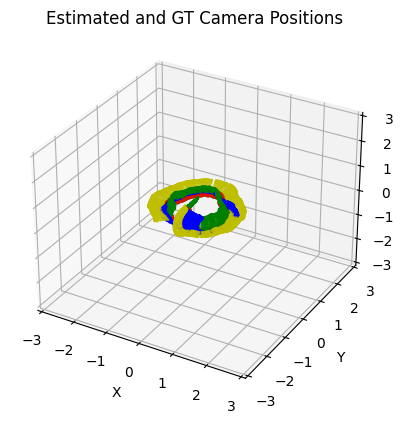

<Figure size 640x480 with 0 Axes>

In [107]:
# train
gt_rotations = []
gt_translations = []
est_rotations = []
est_translations = []
for k in refined_transforms[0].keys():
    gt_rotations.append(transforms[k]['rotation'])
    gt_translations.append(transforms[k]['translation'])

    est_rotations.append(refined_transforms[0][k]['rotation'])
    est_translations.append(refined_transforms[0][k]['translation'])

gt_rotations_tst = []
gt_translations_tst = []
est_rotations_tst = []
est_translations_tst = []
for k in refined_transforms[1].keys():
    gt_rotations_tst.append(transforms[k]['rotation'])
    gt_translations_tst.append(transforms[k]['translation'])

    est_rotations_tst.append(refined_transforms[1][k]['rotation'])
    est_translations_tst.append(refined_transforms[1][k]['translation'])

visualize_multiple_transforms_with_lines(est_rotations, est_translations, est_rotations, est_translations)


In [85]:
def align_ground_truth(gt_rotations, gt_translations, est_rotations, est_translations):
    """
    Align estimated poses with ground truth poses using Procrustes alignment.
    
    Parameters:
    - gt_translations: (N, 3) Ground truth translations
    - est_translations: (N, 3) Estimated translations
    - gt_rotations: (N, 3, 3) Ground truth rotation matrices
    - est_rotations: (N, 3, 3) Estimated rotation matrices
    
    Returns:
    - aligned_est_translations: (N, 3) Aligned estimated translations
    - aligned_est_rotations: (N, 3, 3) Aligned estimated rotation matrices
    - R_align: (3, 3) Global rotation matrix
    - t_align: (3,) Global translation vector
    """
    # Convert inputs to numpy arrays
    gt_translations = np.array(gt_translations)
    est_translations = np.array(est_translations)
    gt_rotations = np.array(gt_rotations)
    est_rotations = np.array(est_rotations)

    # Step 1: Compute centroids
    gt_centroid = np.mean(gt_translations, axis=0)
    est_centroid = np.mean(est_translations, axis=0)

    # Step 2: Center the translations
    gt_centered = gt_translations - gt_centroid
    est_centered = est_translations - est_centroid

    # Step 3: Compute the optimal rotation (using SVD)
    H = est_centered.T @ gt_centered  # Cross-covariance matrix
    U, _, Vt = np.linalg.svd(H)
    R_align = Vt.T @ U.T
    # Ensure proper rotation (det(R) = 1)
    if np.linalg.det(R_align) < 0:
        Vt[2, :] *= -1
        R_align = Vt.T @ U.T

    # Step 4: Compute the translation
    t_align = gt_centroid - R_align @ est_centroid

    # Step 5: Apply the global transformation to translations
    aligned_est_translations = (R_align @ est_translations.T).T + t_align

    # Step 6: Apply the rotation to the orientations
    aligned_est_rotations = np.array([R_align @ R_est for R_est in est_rotations])

    return R_align, t_align, aligned_est_rotations, aligned_est_translations



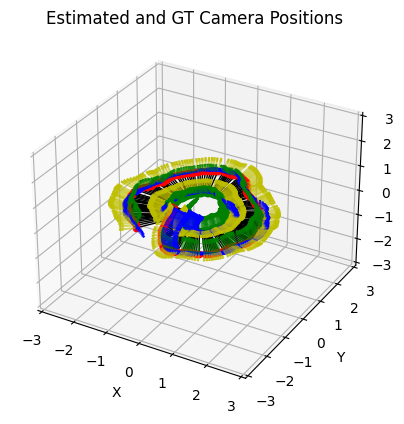

In [114]:
_, _, gt_rotations, gt_translations = align_ground_truth(est_rotations, est_translations, gt_rotations, gt_translations)
visualize_multiple_transforms_with_lines(est_rotations, est_translations, gt_rotations, gt_translations/2)

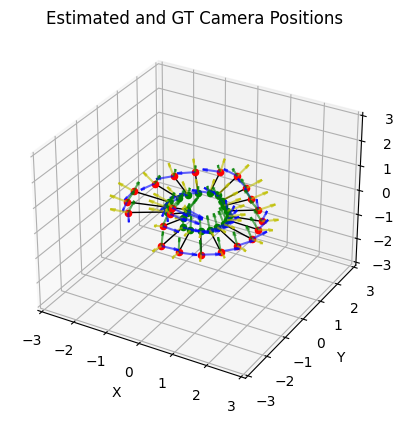

In [115]:
_, _, gt_rotations_tst, gt_translations_tst = align_ground_truth(est_rotations_tst, est_translations_tst, gt_rotations_tst, gt_translations_tst)
visualize_multiple_transforms_with_lines(est_rotations_tst, est_translations_tst, gt_rotations_tst, gt_translations_tst/2)